In [1]:
import numpy as np
import glob
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import plot_model # For plotting the model architecture

# Custom loss function (from your original code)
def combined_loss(y_true, y_pred):
    """
    Calculates the mean squared error loss between true and predicted values.
    """
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return mse_loss

# --- Define the Frame-by-Frame Autoencoder Model ---
# This model is designed to take a single grayscale image (232x232x1) as input
# and reconstruct it.

model = Sequential()

# Encoder layers (Downsampling using Conv2D)
# Input shape for a single grayscale image: (height, width, channels) -> (232, 232, 1)
model.add(Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', 
                 input_shape=(232,232,1), activation='relu', name='encoder_conv1'))
model.add(BatchNormalization(name='encoder_bn1'))
model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', 
                 activation='relu', name='encoder_conv2'))
model.add(BatchNormalization(name='encoder_bn2'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2,2), padding='same', 
                 activation='relu', name='encoder_conv3'))
model.add(BatchNormalization(name='encoder_bn3'))

# Decoder layers (Upsampling using Conv2DTranspose)
model.add(Conv2DTranspose(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', 
                          activation='relu', name='decoder_convT1'))
model.add(BatchNormalization(name='decoder_bn1'))
model.add(Conv2DTranspose(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', 
                          activation='relu', name='decoder_convT2'))
model.add(BatchNormalization(name='decoder_bn2'))
model.add(Conv2DTranspose(filters=32, kernel_size=(7,7), strides=(2,2), padding='same', 
                          activation='relu', name='decoder_convT3'))
model.add(BatchNormalization(name='decoder_bn3'))

# Output layer: Reconstructs a single grayscale image (232x232x1)
# Using 'tanh' activation because your preprocessing normalizes to [-1, 1].
model.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', 
                 activation='tanh', name='output_conv'))

# Display model summary
model.summary()

# Plot the model architecture to a file
# This requires pydot and graphviz to be installed:
# pip install pydot graphviz
# (You might also need to install graphviz executables on your system)
try:
    plot_model(model, to_file="autoencoder_model.png", show_shapes=True, show_layer_names=True)
    print("Model architecture plot saved to 'autoencoder_model.png'")
except ImportError:
    print("Could not plot model. Please install pydot and graphviz.")
except Exception as e:
    print(f"An error occurred while plotting the model: {e}")





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_conv1 (Conv2D)      (None, 116, 116, 64)      3200      
                                                                 
 encoder_bn1 (BatchNormaliza  (None, 116, 116, 64)     256       
 tion)                                                           
                                                                 
 encoder_conv2 (Conv2D)      (None, 58, 58, 128)       204928    
                                                                 
 encoder_bn2 (BatchNormaliza  (None, 58, 58, 128)      512       
 tion)                                                           
                                                                 
 encoder_conv3 (Conv2D)      (None, 29, 29, 256)       295168    
                                                                 
 encoder_bn3 (BatchNormaliza  (None, 29, 29, 256)      1

In [2]:


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=combined_loss, metrics=['mse', 'mae'])

# --- Dataset Loading and Preparation ---
# Load the preprocessed training data (individual frames)
# This assumes 'training_frames.npy' is generated by the data processing script
training_data_path = '../dataset/training_frames.npy'
if not os.path.exists(training_data_path):
    print(f"Error: Training data not found at '{training_data_path}'.")
    print("Please run the 'Frame-by-Frame Data Processing for Autoencoder' script first.")
    exit()

training_data = np.load(training_data_path)
print(f"Shape of loaded training data: {training_data.shape}")

# Ensure the training data has the expected shape (num_samples, height, width, channels)
# The data processing script should already output (num_frames, 232, 232, 1)
if training_data.ndim == 3: # If it's (num_samples, H, W), add channel dim
    training_data = np.expand_dims(training_data, axis=-1)
elif training_data.ndim != 4 or training_data.shape[-1] != 1:
    print(f"Warning: Training data has unexpected shape {training_data.shape}. Expected (num_samples, 232, 232, 1).")
    # You might need to add more robust reshaping or error handling here
    # if your data processing is inconsistent.

print(f"Shape of training data for model input: {training_data.shape}")

# For an autoencoder, the target data is simply a copy of the input data
target_data = training_data.copy()

# --- Training Parameters ---
epochs = 10
batch_size = 32 # Increased batch size for more stable training (adjust as needed)

# Callbacks for saving the best model and early stopping
# 'restore_best_weights=True' ensures the model reverts to the best weights found during training
callback_save = ModelCheckpoint("../models/model.h5", monitor="loss", 
                                verbose=1, save_best_only=True, mode='min')
callback_early_stopping = EarlyStopping(monitor='loss', patience=5, 
                                        restore_best_weights=True, mode='min', verbose=1)

# --- Train the Model ---
print("\nStarting model training...")
history = model.fit(training_data, target_data, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[callback_save, callback_early_stopping],
                    shuffle=True) # Shuffle data for better training

print("\nModel training complete.")


Shape of loaded training data: (67, 232, 232, 1)
Shape of training data for model input: (67, 232, 232, 1)

Starting model training...
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.6445 - mse: 0.6445 - mae: 0.6592
Epoch 1: loss improved from inf to 0.64454, saving model to ../models\model.h5
3/3 [==============================] - 8s 381ms/step - loss: 0.6445 - mse: 0.6445 - mae: 0.6592
Epoch 2/10
2/3 [===================>..........] - ETA: 0s - loss: 0.2176 - mse: 0.2176 - mae: 0.3864
Epoch 2: loss improved from 0.64454 to 0.21481, saving model to ../models\model.h5
3/3 [==============================] - 1s 177ms/step - loss: 0.2148 - mse: 0.2148 - mae: 0.3832
Epoch 3/10
2/3 [===================>..........] - ETA: 0s - loss: 0.1233 - mse: 0.1233 - mae: 0.2787
Epoch 3: loss improved from 0.21481 to 0.12247, saving model to ../models\model.h5
3/3 [==============================] - 1s 178ms/step - loss: 0.1225 - mse: 0.1225 - mae: 0.2776
Epoch 4/10
2/3 [=============

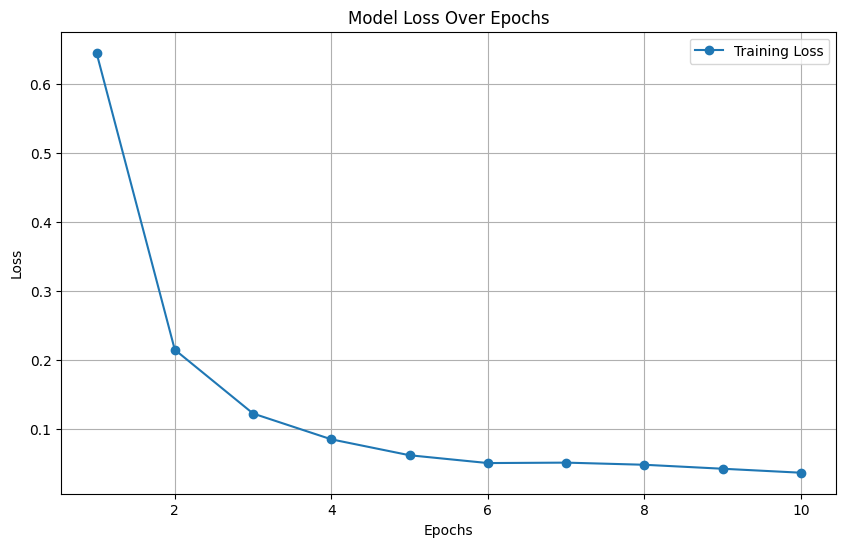

In [3]:
# --- Plot Training History ---
# Ensure matplotlib is installed: pip install matplotlib
history_dict = history.history
loss_values = history_dict['loss']
# If you have validation loss, you can plot it too: val_loss_values = history_dict['val_loss']
epochs_range = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss_values, 'o-', label="Training Loss")
# plt.plot(epochs_range, val_loss_values, 'o-', label="Validation Loss") # Uncomment if using validation split
plt.title("Model Loss Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_graph.jpeg") # Uncomment to save the plot
plt.show()